Group 3
1. Do states with coal power plants have dirtier air?

2. Which power plants are within 75 miles of New York City?

3. Map all of the power plants in New York, New Jersey, Pennsylvania and Connecticut. Have a nice bottom layer of those 4 states.

4. What is the most popular power source by state?

5. Get the average (or highest/worst) PM2.5 within XXX miles of each power plant (you pick the distance). Is coal dirtier than other kinds of plants?

6. Make a map of the power plants within 150 miles of New York City. I want it centered on New York City, zoomed in a good amount.

7. Are places with below-average air quality closer to power plants?

In [1]:
#0. importing and opening

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
states = gpd.read_file('cb_2016_us_state_500k/cb_2016_us_state_500k.shp')

In [4]:
df = pd.read_csv("pm25_annual_fixed.csv")
points = df.apply(lambda row : Point(row.Longitude, row.Latitude), axis=1)
pm25 = gpd.GeoDataFrame(df, geometry=points)

In [5]:
df = pd.read_csv("powerplants.csv")
points = df.apply(lambda row : Point(row.Longitude, row.Latitude), axis=1)
powerplants = gpd.GeoDataFrame(df, geometry=points)

In [6]:
state_CO2 = pd.read_csv("Total Carbon Dioxide Emissions-StateRankings.csv")

Do states with coal power plants have dirtier air?

In [7]:
# only coal power plants
coal_plants = powerplants[powerplants.PrimSource=='coal']

In [8]:
# counting coal plants by state
states['coal_plant_count'] = states.apply(lambda row: coal_plants.within(row.geometry).sum(), axis=1)

In [9]:
# adding to each state average PM2.5 values
pm25_mean = pd.DataFrame(pm25.groupby('State Name')[['State Code','State Name','Arithmetic Mean']].mean().reset_index())
states_merged = pd.merge(states, pm25_mean,left_on='NAME',right_on='State Name', how='left')

In [10]:
states_merged['pm25_mean'] = states_merged['Arithmetic Mean']

In [11]:
states_pm25 = pd.DataFrame(states_merged[['State Name','pm25_mean','coal_plant_count']].dropna())

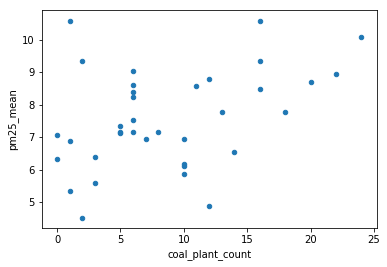

In [12]:
states_pm25 = states_pm25.reset_index()
states_pm25.plot(kind='scatter',x='coal_plant_count', y='pm25_mean')

--> Answer (1): The scatter plot doesn't show a strong realtionship between pollution (pm25) and coal plants

Which power plants are within 75 miles of New York City?

In [13]:
nyc_point = Point(-73.935242,40.730610)

In [14]:
nyc_df = pd.DataFrame(columns=['Name','Point'])
nyc_df = nyc_df.append({'Name':'New York City','Point':nyc_point},ignore_index=True)
nyc_geo = gpd.GeoDataFrame(nyc_df, geometry='Point')

In [15]:
# continental USA
bounds = [
            [
              -127.61718749999999,
              24.5271348225978
            ],
            [
              -65.390625,
              24.5271348225978
            ],
            [
              -65.390625,
              50.28933925329178
            ],
            [
              -127.61718749999999,
              50.28933925329178
            ],
            [
              -127.61718749999999,
              24.5271348225978
            ]
          ]

continentalUS = Polygon(bounds)

In [16]:
states = states[states.within(continentalUS)]

(-2586829.4388886895,
 2488915.8729062313,
 167837.18358806512,
 3315650.3366556843)

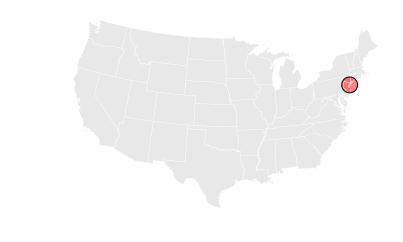

In [17]:
# Miles in km: 75*1.6 = 120
states_proj = states.to_crs(epsg=5071)
nyc_geo.crs = {'init':'epsg:4326'}
nyc_geo_proj = nyc_geo.to_crs(epsg=5071)
ax = states_proj.plot(linewidth= 0.25, color='lightgrey', edgecolor = 'white')
nyc_geo_proj.buffer(120000).plot(color='red',ax=ax)
ax.axis('off')

In [18]:
nycgeo_buffer = nyc_geo_proj.buffer(120000)

In [19]:
nycgeo_buffer = nycgeo_buffer.to_crs(epsg=4326)

In [20]:
powerplants[powerplants.within(nycgeo_buffer.iloc[0])]['Plant_Name']

341                           Rocky River (CT)
342                                   Branford
343                               Bulls Bridge
344                                    Cos Cob
345                              Devon Station
350                                    Shepaug
351                                  Stevenson
362                         Bridgeport Station
1147                              Oyster Creek
1148                                Sayreville
1149                                   Gilbert
1150                 Bergen Generating Station
1151        PSEG Burlington Generating Station
1152             PSEG Essex Generating Station
1153            PSEG Hudson Generating Station
1154            PSEG Kearny Generating Station
1155            PSEG Linden Generating Station
1156            PSEG Mercer Generating Station
1158           PSEG Sewaren Generating Station
1169             Danskammer Generating Station
1175            Arthur Kill Generating Station
1176         

Map all of the power plants in New York, New Jersey, Pennsylvania and Connecticut. Have a nice bottom layer of those 4 states.

In [21]:
states_NE = states[states['NAME'].isin(
            ['New York','New Jersey','Pennsylvania','Connecticut'])]

In [22]:
states_NE_polygon = states_NE.unary_union
powerplants_NE = powerplants[powerplants.within(states_NE_polygon)]

(-80.956535849999995, -71.35034915, 38.624152450000004, 45.320216549999998)

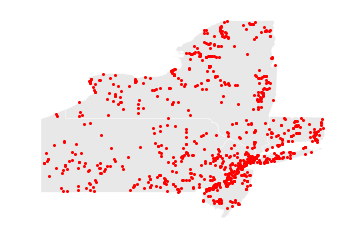

In [23]:
ax = states_NE.plot(linewidth= 0.25, 
                      color='lightgrey', edgecolor = 'white')
powerplants_NE.plot(color='red', ax=ax)
ax.axis('off')

What is the most popular power source by state?

In [24]:
powerplants['states'] = powerplants.apply(lambda row: states[states.contains(row.geometry)]['NAME'].sum(), axis=1)

In [25]:
#using total Megawatt as total production
powerplants.groupby(['states','PrimSource'])['Total_MW'].sum().sort_values(ascending=False).groupby(level=0).head(1)

states                PrimSource   
Texas                 natural gas      67719.2
California            natural gas      42443.5
0                     natural gas      38741.1
Washington            hydroelectric    26652.6
New York              natural gas      21184.4
Louisiana             natural gas      18826.2
Indiana               coal             16596.1
Georgia               natural gas      16580.1
Ohio                  coal             15322.0
Illinois              coal             14902.8
Pennsylvania          natural gas      14757.7
Oklahoma              natural gas      13766.7
Kentucky              coal             13422.7
Arizona               natural gas      13412.7
West Virginia         coal             12969.0
Missouri              coal             12572.9
New Jersey            natural gas      12096.6
Virginia              natural gas      11860.8
Mississippi           natural gas      11593.4
Alabama               natural gas      11386.0
North Carolina        co

Get the average (or highest/worst) PM2.5 within XXX miles of each power plant (you pick the distance). Is coal dirtier than other kinds of plants?<br>
Taking highest PM2.5 in a distance of 10 km.

In [26]:
powerplants_proj = powerplants[['Plant_Code','Plant_Name','PrimSource','geometry']]
powerplants_proj.crs = {'init':'epsg:4326'}
powerplants_proj = powerplants_proj.to_crs(epsg=5071)

In [27]:
powerplants_proj_buffer = powerplants_proj.buffer(10000)

In [28]:
pm25_proj = pm25
pm25_proj.crs = {'init':'epsg:4326'}
pm25_proj = pm25_proj.to_crs(epsg=5071)

In [29]:
powerplants_proj['PM25'] = powerplants_proj_buffer.apply(
    lambda row: pm25_proj[pm25_proj.within(row)]['1st Max Value'].max())

In [30]:
powerplants_proj.groupby('PrimSource')['PM25'].median().sort_values(ascending=False)

PrimSource
geothermal        30.7
nuclear           23.6
solar             21.4
coal              21.2
other             21.0
petroleum         20.6
natural gas       20.4
biomass           20.3
hydroelectric     19.4
wind              17.9
pumped storage     NaN
Name: PM25, dtype: float64

In [31]:
#It doesn't seem that coal power plants increase the PM2.5 values (median of maximum PM2.5 values in a 10km radius)

Make a map of the power plants within 150 miles of New York City. I want it centered on New York City, zoomed in a good amount.

In [32]:
#150 miles are 240 km
nycgeo_buffer = nyc_geo_proj.buffer(240000)
powerplants_proj['close_NYC'] = powerplants_proj_buffer.apply(
    lambda row: nycgeo_buffer.contains(row))

(1400000.0, 2200000.0, 1800000.0, 2600000.0)

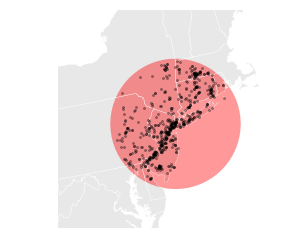

In [33]:
ax = states_proj.plot(linewidth= 0.25, color='lightgrey', edgecolor = 'white')
ax.set_xlim(1400000,2200000)
ax.set_ylim(1800000,2600000)
nycgeo_buffer.plot(alpha=0.4, color='red',ax=ax, edgecolor = 'none')
powerplants_proj[powerplants_proj['close_NYC'] == True].plot(alpha=0.3, color='black',ax=ax)
ax.axis('off')

Are places with below-average air quality closer to power plants?

In [34]:
powerplants_proj_union = powerplants_proj.unary_union

In [35]:
#Calculate distance from power plant

pm25_proj['distance'] = pm25_proj.distance(powerplants_proj_union)

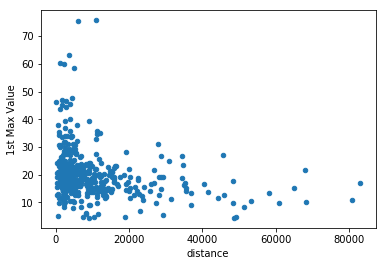

In [36]:
pm25_chart_df = pd.DataFrame(pm25_proj)
pm25_chart_df.plot(kind='scatter',y='1st Max Value', x='distance')

In [37]:
#Yes! The highest pollution can be seen near a power plant.